# Noisy-Clustering

In [1]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tfhub
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib

In [2]:
txt_dir = "../datasets/cleaned_datasets/clean_dataset" 

## Reading Data into DataFrame

In [3]:
def read_data(_dir:str) -> pd.DataFrame:
    data = {}
    data["url"] = []
    data["text"] = []
    data["class"] = []
    for root, dirs, files in os.walk(_dir):
        for _dir in dirs: 
            for txt_file in [x for x in os.listdir(os.path.join(root, _dir)) if x.endswith((".txt", ".TXT"))]:
                # Class name = dir name
                class_name = _dir
                #Read File
                file_name = os.path.abspath(os.path.join(root, _dir, txt_file))
                file = open(file_name, "r")
                txt = file.read()
                file.close()
                data["url"].append(file_name)
                data["text"].append(txt)
                data["class"].append(class_name)
    df = pd.DataFrame.from_dict(data)
    del data
    return df

In [4]:
%%time
df = read_data(txt_dir)

CPU times: user 652 ms, sys: 754 ms, total: 1.41 s
Wall time: 2.43 s


In [5]:
df.head()

,url,text,class
0,/Users/Daniel/PycharmProjects/Recommender-Syst...,the goal of feature selection in text classifi...,prediction
1,/Users/Daniel/PycharmProjects/Recommender-Syst...,conclusion a major assumption of regression or...,prediction
2,/Users/Daniel/PycharmProjects/Recommender-Syst...,in category as a supervised machine process is...,prediction
3,/Users/Daniel/PycharmProjects/Recommender-Syst...,the pls regression is used to connect the depe...,prediction
4,/Users/Daniel/PycharmProjects/Recommender-Syst...,pace regression the basic idea of regression a...,prediction


## Get the Embeddings

In [6]:
model_url = "./DAN/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/"

In [7]:
%%time
model = tfhub.Module(model_url)

CPU times: user 1.68 s, sys: 115 ms, total: 1.8 s
Wall time: 1.8 s


In [8]:
sess = tf.InteractiveSession()

In [9]:
sess.run([tf.global_variables_initializer(), tf.tables_initializer()])

[None, None]

In [10]:
%%time
embeddings = sess.run(model(list(df["text"])))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
CPU times: user 11 s, sys: 887 ms, total: 11.9 s
Wall time: 10.7 s


In [11]:
sess.close()

In [12]:
print(df.shape)
print(embeddings.shape)

(10306, 3)
(10306, 512)


## Dimensionality Reduction

### 3D PCA

In [13]:
pca = PCA(n_components=3)

In [14]:
embeddings_lst = []

for emb in embeddings: 
    embeddings_lst.append(emb)

In [15]:
matrix = pca.fit_transform(embeddings_lst)

In [16]:
matrix.shape

(10306, 3)

In [17]:
df["x"] = matrix[:,0]
df["y"] = matrix[:,1]
df["z"] = matrix[:,2]

### 2D PCA

In [18]:
pca = PCA(n_components=2)

In [19]:
embeddings_lst = []

for emb in embeddings: 
    embeddings_lst.append(emb)

In [20]:
matrix = pca.fit_transform(embeddings_lst)

In [21]:
df["a"] = matrix[:,0]
df["b"] = matrix[:,1]

In [22]:
df.head()

,url,text,class,x,y,z,a,b
0,/Users/Daniel/PycharmProjects/Recommender-Syst...,the goal of feature selection in text classifi...,prediction,-0.060098,0.140111,0.214230,-0.060102,0.140103
1,/Users/Daniel/PycharmProjects/Recommender-Syst...,conclusion a major assumption of regression or...,prediction,0.208037,0.044547,-0.011731,0.208039,0.044546
2,/Users/Daniel/PycharmProjects/Recommender-Syst...,in category as a supervised machine process is...,prediction,-0.076284,0.027442,0.402112,-0.076286,0.027440
3,/Users/Daniel/PycharmProjects/Recommender-Syst...,the pls regression is used to connect the depe...,prediction,0.235620,-0.172960,-0.070765,0.235620,-0.172963
4,/Users/Daniel/PycharmProjects/Recommender-Syst...,pace regression the basic idea of regression a...,prediction,0.270748,0.025771,-0.249924,0.270745,0.025768


## Visualization

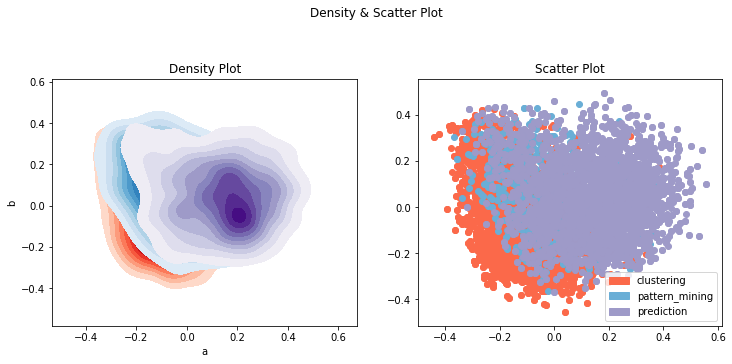

In [23]:
import matplotlib.patches as mpatches


cmaps = ["Reds", "Blues", "Purples","Greens","cool", "Greys","Rainbow"]
colors = ["red", "blue", "purple", "green", "", "grey"]
groups = df.groupby("class")
counter = 0

fig = plt.figure(figsize=(12,10))
fig.suptitle("Density & Scatter Plot")

ax_1 = fig.add_subplot(2,2,1)
ax_2 = fig.add_subplot(2,2,2)
ax_1.set_title("Density Plot")
ax_2.set_title("Scatter Plot")

labels = []
for name, group in groups: 
    ax = sns.kdeplot(group.a,group.b, shade=True, cmap = cmaps[counter],shade_lowest=False, ax = ax_1)
    color_from_cmap = matplotlib.cm.get_cmap(cmaps[counter])(0.5)
    ax_2.scatter(group.a, group.b, color = color_from_cmap)
    labels.append(mpatches.Patch(color=color_from_cmap, label=name))
    counter +=1
legend = plt.legend(handles = labels)

<IPython.core.display.Javascript object>


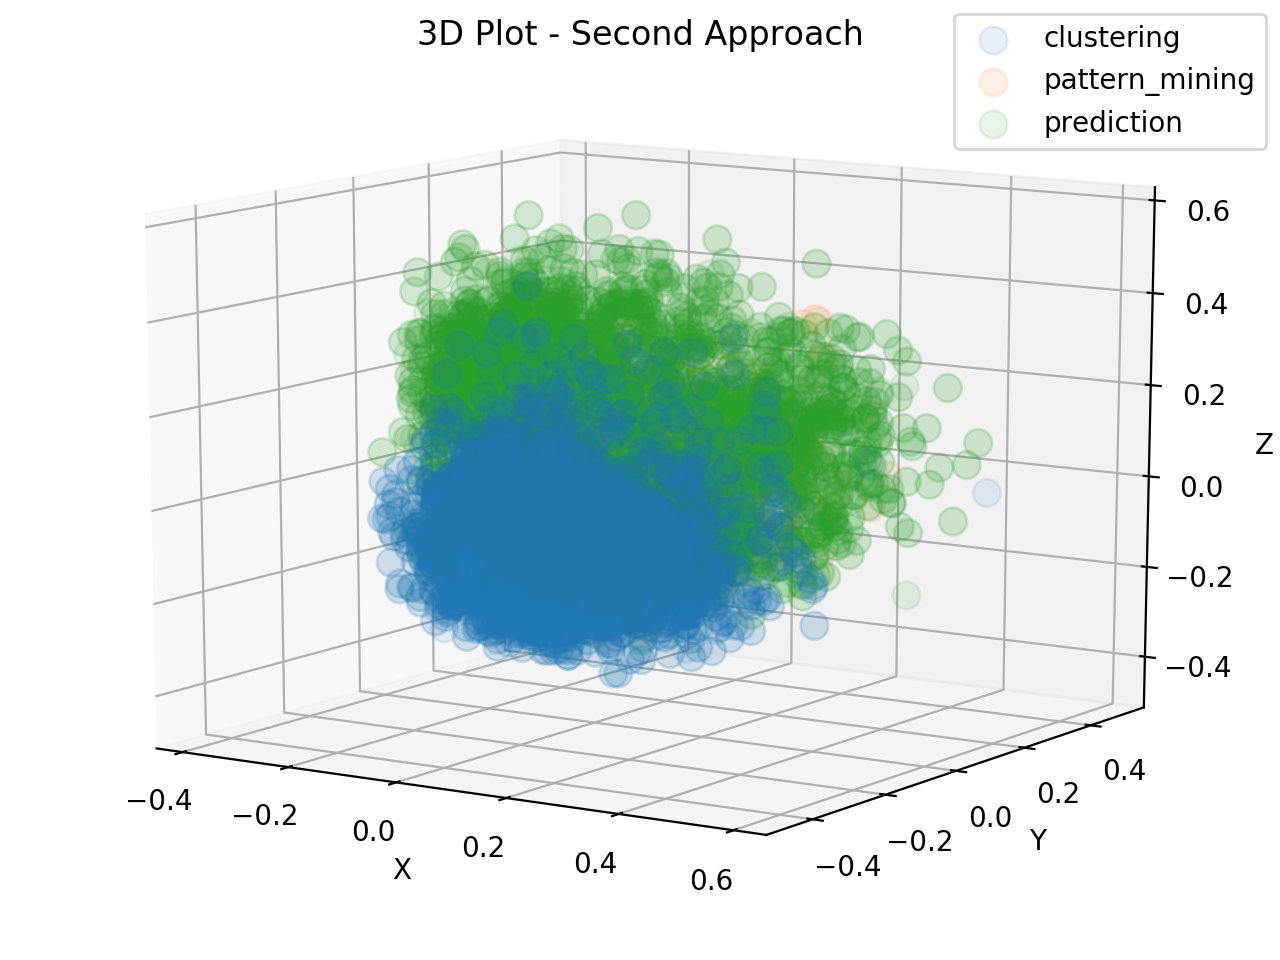

In [24]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
fig.suptitle("3D Plot - Second Approach")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

groups = df.groupby("class")
for name, group in groups:
    
    ax.scatter(group.z, group.y, group.x, s = 100, label=name, alpha = 0.1)
   
    ax.legend()